In [1]:
pip install pyTsetlinMachine

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PyTsetlinMachineCUDA

Note: you may need to restart the kernel to use updated packages.


In [3]:
from PyTsetlinMachineCUDA.tm import MultiClassConvolutionalTsetlinMachine2D
import PyTsetlinMachineCUDA.tm
import pyTsetlinMachine
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.signal import spectrogram
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import random
from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix
import json

In [ ]:
json_file = 'TM_NASA_CTM_Thermometer_avg.json' # Stores the result in here

labels = [1975, 701, 6071] # Train lable index of failure
# Paths to test NASA files
file_paths = [
    "../data/NASA/1_channel_4.mat",
    "../data/NASA/2_channel_0.mat",
    "../data/NASA/3_channel_2.mat"
]
labels_test = [1616] # Benchmark lable index of failure
# Paths to benchmark NASA files
file_paths_test = [
    "../data/NASA/1_channel_6.mat",
]

In [4]:
def load_mat_spectrogram(mat_file_path, num_bits, std_num=3):
    """
    Load a spectrogram from a MATLAB file, process it by normalizing and encoding it using thermometer encoding.
    Optionally plot the normalized spectrogram.

    Parameters:
    mat_file_path (str): Path to the MATLAB file containing the spectrogram and timestamps.
    num_bits (int): Number of bits to use for thermometer encoding.
    std_num (int): Number of standard deviations to use for clipping during standardization.

    Returns:
    tuple: A tuple containing:
           - reshaped_data (np.array): The encoded spectrogram data reshaped for analysis.
           - timestamps (np.array): An array of timestamps associated with each spectrogram column.
    """
    # Load the spectrogram and timestamps from the specified .mat file.
    mat_data = scipy.io.loadmat(mat_file_path)
    spectrogram = mat_data['spectrogram']
    timestamps = mat_data['timestamps'][0]
    
    print("Spectrogram shape before processing:", spectrogram.shape)
    
    # Downsample the spectrogram to reduce resolution.
    spectrogram = zoom(spectrogram, (1/20, 1), order=0)
    print("Spectrogram shape after downscaling:", spectrogram.shape)

    # Standardize by clipping extreme values.
    avg_y = np.mean(spectrogram)
    std_y = np.std(spectrogram)
    clean_y = np.clip(spectrogram, avg_y - std_num * std_y, avg_y + std_num * std_y)

    # Normalize the cleaned spectrogram to the range [0, 1].
    clean_y_min = np.min(clean_y)
    clean_y_max = np.max(clean_y)
    norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min)

    # Encode the normalized spectrogram using thermometer encoding.
    def thermometer_encode(values, num_bits):
        thresholds = np.linspace(0, 1, num_bits + 1, endpoint=False)[1:]
        values_expanded = values[:, :, np.newaxis]
        encoded = (values_expanded >= thresholds).astype(int)
        return encoded

    encoded_spectrogram = thermometer_encode(norm_y, num_bits)
    encoded_spectrogram = np.transpose(encoded_spectrogram, (1, 0, 2))
    
    return encoded_spectrogram, timestamps

In [6]:
def prepros(spectrogram, k_width):
    """
    Reshape a multi-channel spectrogram into overlapping windows of specified width.

    Parameters:
    spectrogram (np.array): The input spectrogram array, assumed to be 3D (time_slices, frequency_bins, channels).
    k_width (int): The number of consecutive slices to include in each window.

    Returns:
    np.array: A 4D array where each window is (k_width, frequency_bins, channels), reshaped across the time dimension.
    """
    # Extract dimensions of the spectrogram
    time_slices = spectrogram.shape[0]
    frequency_bins = spectrogram.shape[1]
    channels = spectrogram.shape[2]
    
    # Ensure the number of time slices is a multiple of k_width
    if time_slices % k_width != 0:
        spectrogram = spectrogram[:-(time_slices % k_width)]
        new_time_slices = spectrogram.shape[0]  # Update number of slices after trimming
    else:
        new_time_slices = time_slices

    # Initialize an empty array to store reshaped data
    reshaped_data = np.empty((new_time_slices - k_width + 1, k_width, frequency_bins, channels))

    # Populate the reshaped data array using a sliding window approach
    for i in range(new_time_slices - k_width + 1):
        reshaped_data[i] = spectrogram[i:i + k_width]

    return reshaped_data

In [7]:
def process_spectrograms(labels, file_paths, k_width, bits):
    """
    Process spectrograms to generate labeled data arrays suitable for machine learning. The data is segmented
    into classes based on timestamps, transposed, and then reshaped into overlapping windows.

    Parameters:
    labels (list): A list of labels indicating the change point in time for each spectrogram.
    file_paths (list): A list of paths to the spectrogram files.
    k_width (int): The number of consecutive slices to include in each window of the output array.

    Returns:
    tuple: A tuple containing two numpy arrays:
           - x_data: Array of reshaped spectrogram data for model input.
           - y_data: Array of binary labels corresponding to each window of spectrogram data.
    """
    x_data = []
    y_data = []

    # Process each spectrogram file along with its label.
    for label, path in zip(labels, file_paths):
        spectrogram, time_hours = load_mat_spectrogram(path, bits)
        y = np.zeros(len(time_hours), dtype=np.int32)
        for i in range(len(time_hours)):
            y[i] = 0 if i < label else 1

        # Separate the spectrogram into two classes based on the label.
        num_ones = np.count_nonzero(y)
        num_zeros = len(y) - num_ones
        
        class_0 = np.array(spectrogram[0:num_zeros])
        class_1 = np.array(spectrogram[num_zeros:num_zeros + num_ones])

        # Process each class and reshape into windows of size k_width.
        class_0 = prepros(class_0, k_width)
        y_class_0 = np.full(class_0.shape[0], 0)
        class_1 = prepros(class_1, k_width)
        y_class_1 = np.full(class_1.shape[0], 1)
        
        # Append processed data and labels to the respective lists.
        x_data.append(class_0)
        y_data.append(y_class_0)
        x_data.append(class_1)
        y_data.append(y_class_1)

    # Convert lists to numpy arrays for handling varying sizes.
    x_data = np.array(x_data, dtype=object)
    y_data = np.array(y_data, dtype=object)

    return x_data, y_data


In [8]:
# Define parameters for window size, bits and paths for training and testing data
bits = 8
k_width = 5


# Process training data
x_data, y_data = process_spectrograms(labels, file_paths, bits, k_width)
x_data = np.vstack(x_data)
flattened_data = x_data.reshape(-1, x_data.shape[1] * x_data.shape[2], x_data.shape[3])
flattened_array = np.concatenate(y_data)

# Process testing data
x_data_test, y_data_test = process_spectrograms(labels_test, file_paths_test, bits, k_width)
x_data_test = np.vstack(x_data_test)
flattened_data_test = x_data_test.reshape(-1, x_data_test.shape[1] * x_data_test.shape[2], x_data_test.shape[3])
flattened_array_test = np.concatenate(y_data_test)

# Data now ready for model training/testing

Spectrogram shape before processing: (2156, 512, 8)
spec shape after tranform (2156, 512, 8)
class 0 shape before prerpos (1975, 512, 8)
class 1 shape before prerpos (181, 512, 8)
time_slices = spectrogram.shape[0] 1975
frequency_bins = spectrogram.shape[1] 512
channels = spectrogram.shape[2] 8
class 0 shape (1971, 5, 512, 8)
time_slices = spectrogram.shape[0] 181
frequency_bins = spectrogram.shape[1] 512
channels = spectrogram.shape[2] 8
class 1 shape (176, 5, 512, 8)
(176,)
(1971,)
Spectrogram shape before processing: (984, 512, 8)
spec shape after tranform (984, 512, 8)
class 0 shape before prerpos (701, 512, 8)
class 1 shape before prerpos (283, 512, 8)
time_slices = spectrogram.shape[0] 701
frequency_bins = spectrogram.shape[1] 512
channels = spectrogram.shape[2] 8
class 0 shape (696, 5, 512, 8)
time_slices = spectrogram.shape[0] 283
frequency_bins = spectrogram.shape[1] 512
channels = spectrogram.shape[2] 8
class 1 shape (276, 5, 512, 8)
(276,)
(696,)
Spectrogram shape before pro

In [9]:
print(flattened_data.shape)
print(flattened_array.shape)
print(flattened_data_test.shape)
print(flattened_array_test.shape)

(9431, 2560, 8)
(9431,)
(2147, 2560, 8)
(2147,)


Epoch 1 - Test Accuracy: 96.61%, F1 Score: 0.82
Epoch 1 - Unseen Accuracy: 99.49%, F1 Score: 0.99
Epoch 21 - Test Accuracy: 98.73%, F1 Score: 0.95
Epoch 21 - Unseen Accuracy: 99.72%, F1 Score: 1.00
Epoch 41 - Test Accuracy: 98.89%, F1 Score: 0.95
Epoch 41 - Unseen Accuracy: 99.63%, F1 Score: 1.00
Epoch 61 - Test Accuracy: 99.42%, F1 Score: 0.98
Epoch 61 - Unseen Accuracy: 99.35%, F1 Score: 0.99
Epoch 1 - Test Accuracy: 96.66%, F1 Score: 0.83
Epoch 1 - Unseen Accuracy: 99.67%, F1 Score: 1.00
Epoch 21 - Test Accuracy: 99.10%, F1 Score: 0.96
Epoch 21 - Unseen Accuracy: 99.21%, F1 Score: 0.99
Epoch 41 - Test Accuracy: 99.15%, F1 Score: 0.96
Epoch 41 - Unseen Accuracy: 99.12%, F1 Score: 0.99
Epoch 61 - Test Accuracy: 99.42%, F1 Score: 0.98
Epoch 61 - Unseen Accuracy: 99.02%, F1 Score: 0.99
Epoch 1 - Test Accuracy: 96.45%, F1 Score: 0.81
Epoch 1 - Unseen Accuracy: 99.67%, F1 Score: 1.00
Epoch 21 - Test Accuracy: 99.10%, F1 Score: 0.96
Epoch 21 - Unseen Accuracy: 99.16%, F1 Score: 0.99
Epoch 

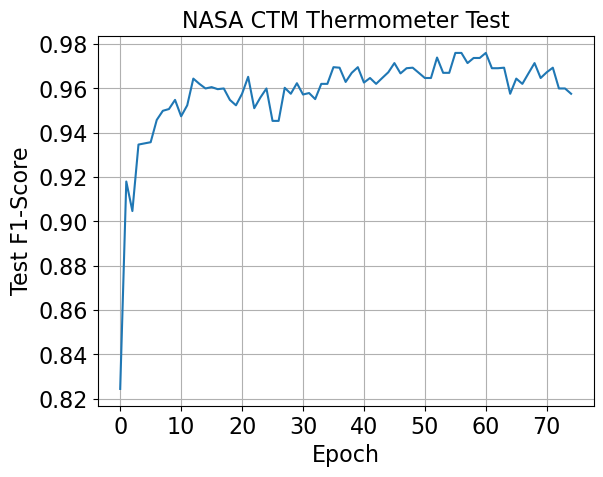

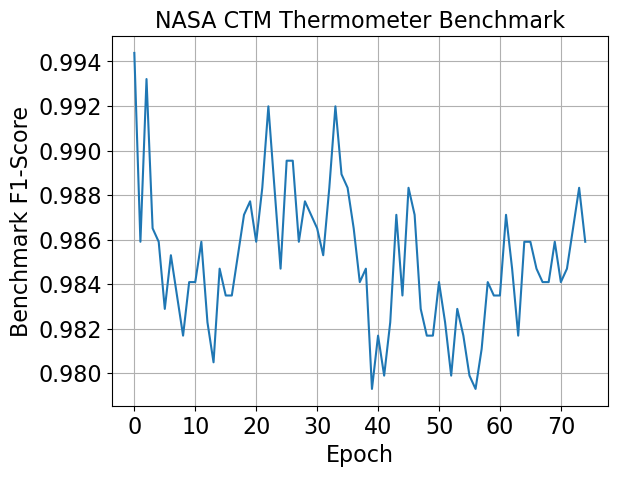

In [10]:
C = flattened_data.shape[1] 
T = np.power((C/0.8377),1/2.2099)
s = 2.534*np.log((C/3.7579))

X_train, X_test, y_train, y_test = train_test_split(flattened_data, flattened_array, test_size=0.2)



training_steps = 75
epochs = 1
runs = 1 # Number of runs in total the Tsetlin Machine will do

for i in range(runs):
    epoch_accuracies = []
    epoch_unseen = []
    epoch_accuracies_f1 = []
    epoch_unseen_f1 = []
    tm = MultiClassConvolutionalTsetlinMachine2D(int(C), T, s,(int(flattened_data.shape[1]),bits)) # Init the Tsetlin Machine
    # Train the machine for one epoch at a time
    for epoch in range(training_steps):
        # Incrementally fit the Tsetlin Machine on each dataset
        tm.fit(X_train, y_train, epochs=epochs, incremental=True) # Train for epoch
        
        Y_pred = tm.predict(X_test)
        accuracy = accuracy_score(y_test, Y_pred)
        f1 = f1_score(y_test, Y_pred, average='macro')  # Using 'macro' to average scores of each class
        if epoch % 20 == 0:
            print(f'Epoch {epoch+1} - Test Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.2f}')
        epoch_accuracies.append(accuracy)
        epoch_accuracies_f1.append(f1)
        a_s = accuracy
        a_s1 = f1
        
        # Prediction and evaluation on unseen data
        Y_pred_unseen = tm.predict(flattened_data_test)
        accuracy_unseen = accuracy_score(flattened_array_test, Y_pred_unseen)
        f1_unseen = f1_score(flattened_array_test, Y_pred_unseen, average='macro')
        if epoch % 20 == 0:
            print(f'Epoch {epoch+1} - Unseen Accuracy: {accuracy_unseen * 100:.2f}%, F1 Score: {f1_unseen:.2f}')
        epoch_unseen.append(accuracy_unseen)
        epoch_unseen_f1.append(f1_unseen)
        a_u = accuracy_unseen
        a_u1 = f1_unseen

        accuracy_data = {
            "epoch_accuracies": epoch_accuracies,
            "epoch_unseen": epoch_unseen
        }

        try:
            with open(json_file, 'r') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {'training_run': [],}
            with open(json_file, 'w') as file:  
                json.dump(data, file)  

        data['training_run'].append({
            'seendata': a_s,
            'unseendata': a_u,
            'seendata_f1': a_s1,
            'unseendata_f1': a_u1,
        })
        
        with open(json_file, 'w') as f:
            json.dump(data, f, indent=4)

plt.plot(epoch_accuracies_f1)
plt.title('NASA CTM Thermometer Test',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Test F1-Score',fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.savefig('../plot/TM_NASA_CTM_Thermometer_test.pdf') # Option for saving plot
plt.show()

plt.plot(epoch_unseen_f1)
plt.title('NASA CTM Thermometer Benchmark',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Benchmark F1-Score',fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.savefig('../plot/TM_NASA_CTM_Thermometer_benchmark.pdf') # Option for saving plot
plt.show()

Confusion Matrix:
[[8732    1]
 [  18  680]]


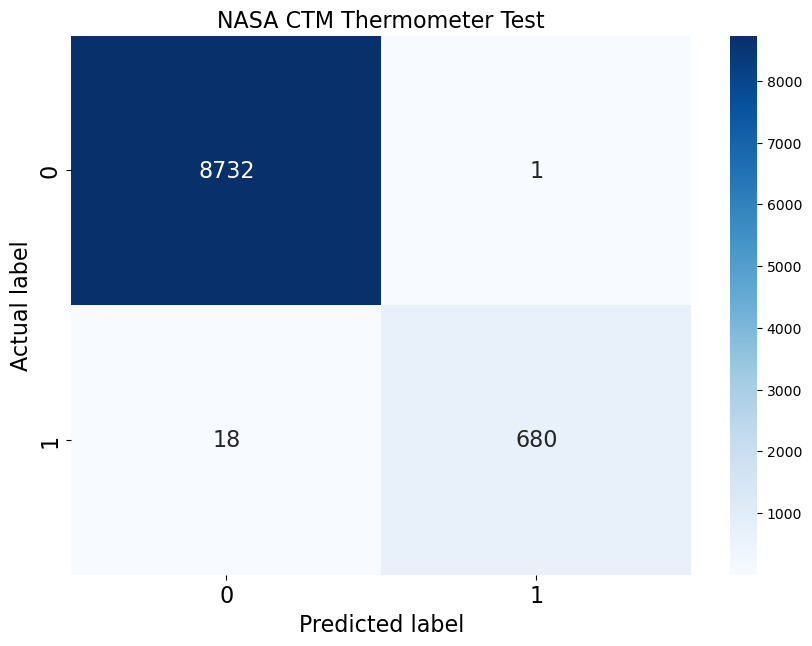

Confusion Matrix:
[[1588   23]
 [   0  536]]


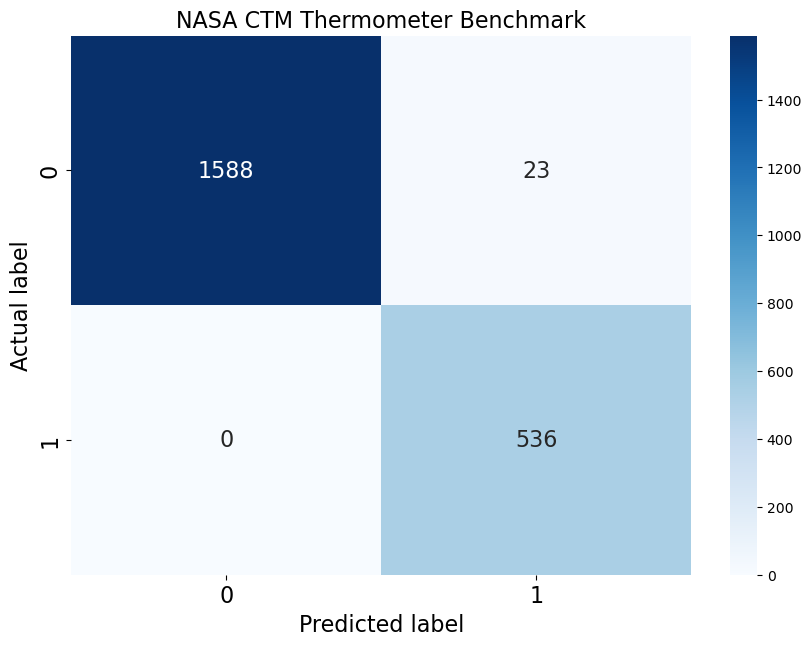

In [11]:
Y_pred = tm.predict(flattened_data)
flattened_array = flattened_array.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(flattened_array, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True,
            annot_kws={"size": 16}) 
plt.title('NASA CTM Thermometer Test', fontsize=16)
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
# plt.savefig('../plot/CM_NASA_CTM_thermometer_test.pdf') # Option for saving plot
plt.show()


Y_pred = tm.predict(flattened_data_test)
flattened_array_test = flattened_array_test.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(flattened_array_test, Y_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True,
            annot_kws={"size": 16})  # Increase size here for annotations
plt.title('NASA CTM Thermometer Benchmark', fontsize=16)  # Increased title font size
plt.ylabel('Actual label', fontsize=16)  # Increased y-axis label font size
plt.xlabel('Predicted label', fontsize=16)  # Increased x-axis label font size
plt.xticks(fontsize=16)  # Increase x-axis tick font size
plt.yticks(fontsize=16)  # Increase y-axis tick font size
# plt.savefig('../plot/CM_NASA_CTM_thermometer_benchmark.pdf') # Option for saving plot
plt.show()

In [13]:
print(C)
print(T)
print(s)

2560
37.76269375507408
16.531568293227163
